In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import combinations

sns.set(style='ticks', context='notebook')

In [2]:
from hivscc_data import load_data, join_gene_data
import hivscc_analysis as utils
human_df, mouse_df, ephys_df, morph_df = load_data()

drop_neg = [
    'input_resistance',
    'fi_fit_slope',
    'sag'
]
for feat in drop_neg:
    mouse_df[feat] = mouse_df[feat].apply(lambda x: x if (x>0) else np.nan)
    human_df[feat] = human_df[feat].apply(lambda x: x if (x>0) else np.nan)

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/pandas/core/common.py:329: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  return maybe_callable(obj, **kwargs)


In [4]:
mfeat_names = pd.read_csv(Path('../data/morpho_feature_names.csv'))
mfeat_dict = mfeat_names.set_index("feature name (old)")["feature name (simple)"].to_dict()

efeat_names = pd.read_csv(Path('../data/ephys_feature_names.csv'), index_col=0)
efeat_short_dict = efeat_names.short_name.to_dict()
efeat_dict = efeat_names.full_name.to_dict()
efeat_units = efeat_names.units_name.to_dict()

In [5]:
palette = {
    'LTK': '#cfe818',
    'GLP2R': '#3db516',
    'FREM3': '#3263b0',
    'CARM1P1': '#6f2af7',
    'COL22A1': '#f057f0',
    'Agmat': '#D10034',
    'Rrad': '#F67415',
    'Adamts2': '#FFC800',
    ' ': 'k',
          }

In [6]:
def outline_boxplot(ax):
    for i,artist in enumerate(ax.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        n=5
        for j in range(i*n,i*n+n):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
            
def plot_box_cluster_feature(data, features, labels=None, strip_width=0.2, pairs_sets=[], cutoff=0.05, 
                            figsize=(4,8), invert_y=False, label_yaxis=False, horizontal=False, pad_title=-10):
    x='cluster'
    n = len(features)
    labels = labels or features
    if horizontal:
        fig, axes = plt.subplots(1,n, figsize=figsize, sharex=True)
    else:    
        fig, axes = plt.subplots(n,1, figsize=figsize, sharex=True)
        
    for i, ax in enumerate(axes):
        y = features[i]
        sns.stripplot(data=data, x=x, y=y, palette=palette, ax=ax, jitter=strip_width, size=3, alpha=0.7)
        sns.boxplot(data=data, x=x, y=y, palette=palette, ax=ax, showfliers=False)
        
        outline_boxplot(ax)
        ax.set_xlabel(None)
        sns.despine()
        if label_yaxis:
            ax.set_ylabel(labels[i])
        else:
            ax.set_ylabel(None)
            ax.set_title(labels[i], loc='right', pad=pad_title)
        ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45, fontstyle='italic')
        ax.set_ylim(0,None, auto=True)
            
        for pairs in pairs_sets:
            group_vals=data[x].cat.categories.to_list()
            utils.plot_mw_bars(data, y, x, group_vals=group_vals, pairs=pairs, ax=ax, cutoff=cutoff, label=None)
            
        ax.set_ylim(0,None, auto=True)
        if invert_y:
            ax.invert_yaxis()

# Fig 3

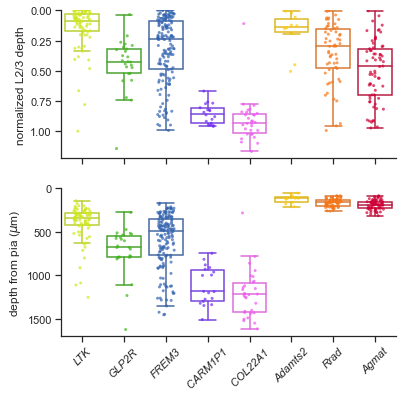

In [7]:
data = pd.concat([human_df, mouse_df], sort=False)

features = [
    'L23_depth_normalized',
    'depth_from_pia_microns',
]
labels = [
    'normalized L2/3 depth',
    'depth from pia ($\mu$m)'
]

plot_box_cluster_feature(data, features, labels, figsize=(6,6), invert_y=True, label_yaxis=True)

# Fig 4

In [8]:
data = pd.concat([human_df.loc[lambda df: df['SeuratMapping'].str.contains("Exc L2")], mouse_df], sort=False)
data.cluster.cat.set_categories(['LTK','FREM3','GLP2R',' ','Agmat', 'Rrad', 'Adamts2'], ordered=True, inplace=True)

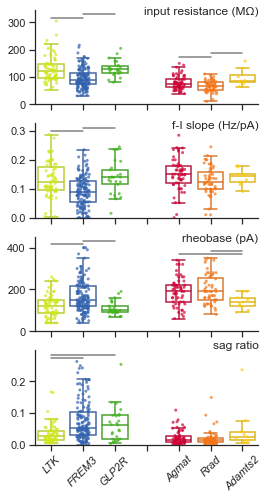

In [9]:
from itertools import combinations
features = [
    'input_resistance',
    'fi_fit_slope',
    'rheobase_i',
    'sag'
]
labels = [efeat_units[feat] for feat in features]
pairs_sets = [list(combinations(['LTK','FREM3','GLP2R'], 2)), list(combinations(['Agmat', 'Rrad', 'Adamts2'], 2))]
plot_box_cluster_feature(data, features, labels, pairs_sets=pairs_sets, pad_title=-5)

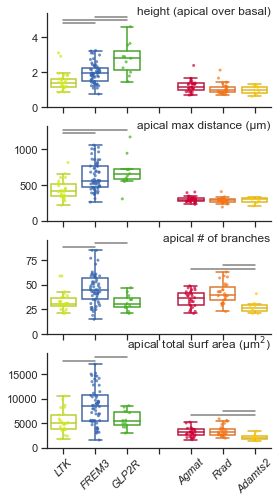

In [10]:
features = [
    'apical_dendrite_over_basal_dendrite_extent_y',
    'apical_dendrite_max_path_distance_none',
    'apical_dendrite_num_branches_none',
    'apical_dendrite_total_surface_none'
]
units = ['',' (μm)','', ' (μm$^2$)']

labels = [mfeat_dict[feat] for feat in features]
labels = [label + unit for label, unit in zip(labels, units)]
plot_box_cluster_feature(data, features, labels, strip_width=0.15, pad_title=-2, pairs_sets=pairs_sets)

# Fig 4 ANOVA

In [11]:
from statsmodels.stats.multitest import multipletests
def run_anova_pairs(mouse_df, human_df, features, pval='pval_cluster', cov_type='HC3', fdr_method='fdr_bh',):
    pval = 'pval_cluster'
    label = 'rsquared'
    fdr_method='fdr_bh'
    
    results = (pd.concat(
        [
        utils.fit_models(human_df, ["cluster"], features, cov_type=cov_type).set_index('feature'),
        utils.fit_models(mouse_df, ["cluster"], features, cov_type=cov_type).set_index('feature'),
        ],
        keys=[
            'human',
            'mouse',
             ],
        axis=1)
        .sort_values(('human','rsquared'), ascending=False)
        .swaplevel(axis=1)
    )
    results = results.dropna(subset=[(pval,'human')])
    results[pval] = (
        results[pval].pipe(pd.DataFrame)#in case this is Series
        .apply(lambda col: multipletests(col, method=fdr_method)[1]).astype(float)
    )
    return results

def plot_cluster_anova_species_bar(mouse_df, human_df, features, pval='pval_cluster', cov_type='HC3', ylabels=None, 
                               figsize=(1.5,8), nshow=20):
    results = run_anova_pairs(mouse_df, human_df, features, cov_type=cov_type)

    data = results.loc[:,pval]
    stars = data.iloc[:nshow].apply(lambda x: pd.cut(x, [0, 0.001, 0.01, 0.05, 1], labels=['***','**','*',''])).astype(str).values


    fig, ax = plt.subplots(figsize=figsize)
    bardata = results.iloc[:nshow].loc[:,'rsquared'].reset_index().melt(id_vars=['feature'])
    
    palette = {
        'human': '#4d8000',
        'mouse': '#a84920'
    }
    sns.barplot(data=bardata, y='feature', x='value', hue='variable', palette=palette)
    sns.despine()
    if ylabels is not None:
        ax.set_yticklabels([ylabels[label.get_text()] for label in ax.get_yticklabels()])
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title('Cluster ANOVA $\eta^2$')
    ax.get_legend().remove()
    
    nfeat = min(nshow, len(ylabels))
    for i, p in enumerate(ax.patches):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        ifeat = i % nfeat
        ispecies = i // nfeat
        annot = stars[ifeat, ispecies]
        if not annot:
            col = p.get_facecolor()
            p.set_edgecolor(col)
            p.set_facecolor('None')
        else:
            space = 0.005
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            ax.text(_x, _y, annot, ha="left")


In [12]:
human = human_df.loc[lambda df: df['SeuratMapping'].str.contains("Exc L2")]
human.cluster.cat.remove_unused_categories(inplace=True)
mouse = mouse_df
mouse.cluster.cat.remove_unused_categories(inplace=True)

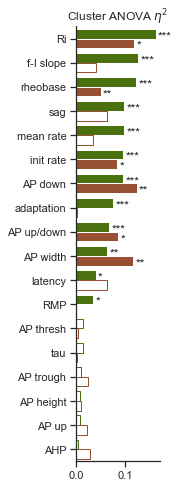

In [13]:
plot_cluster_anova_species_bar(mouse, human, features=ephys_df.columns, ylabels=efeat_short_dict)

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1848: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of con

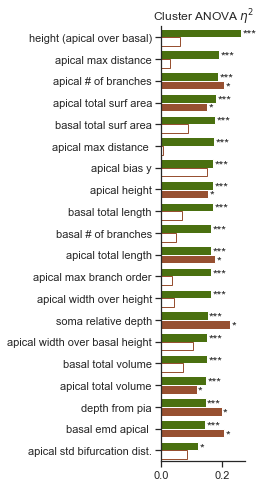

In [14]:
nshow=20
plot_cluster_anova_species_bar(mouse, human, features=morph_df.columns, ylabels=mfeat_dict,  nshow=nshow)

# Fig5 Frem only

In [15]:
def plot_depth_scatters(data, features, labels, horizontal=False):
    x = 'L23_depth_normalized'
    if horizontal:
        fig, axes = plt.subplots(1,3, figsize=(12,2.5), sharex=True)
    else:
        fig, axes = plt.subplots(3,1, figsize=(4,5), sharex=True)
    for i, ax in enumerate(axes):
        res = utils.plot_fit(data, features[i], x, print_pvals=False, palette=palette, ax=ax)
    #     sns.scatterplot(data=data, x=x, y=features[i], palette=palette, ax=ax)
        sns.despine()
        ax.set_ylabel('')
        ax.set_xlabel('normalized L2/3 depth')
        ax.set_title(labels[i], loc='center', pad=5)
        
        summary = "$R^2$={:.2g}".format(res["rsquared"])
        props = dict(boxstyle='round', facecolor='white', alpha=0.6, pad=0.01)
        ax.text(0.01, 0.99, summary, transform=ax.transAxes, bbox=props,
            verticalalignment='top', horizontalalignment='left')
        ax.set_xlim(0,None)
    fig.tight_layout(h_pad=0.5)

In [16]:
umap_t = pd.read_csv(Path('../data/IVSCC_excitatory_L23_Feb2020.csv'), index_col=0)

genes = [
    'RIT2',
    'KCNIP2',
    'KCND2',
    'CNGB1',
    'NTNG1',
    'NRG1',
    'MET',
]

data = human_df[human_df.cluster.str.contains('FREM')].join(umap_t, rsuffix='r')
data = join_gene_data(data, genes)

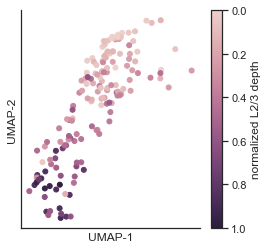

In [17]:
fig, ax = plt.subplots(figsize=(4,4))
x='tUMAP_1'
y='tUMAP_2'
hue='L23_depth_normalized'
cmap = sns.cubehelix_palette(n_colors=100, as_cmap=True)
# sns.scatterplot(data=data, x='tUMAP_1', y='tUMAP_2', hue='L23_depth_normalized', cmap=cmap, legend=False, ax=ax)

# Get a mappable object with the same colormap as the data
points = plt.scatter(data[x], data[y], c=data[hue], vmin=0, vmax=1, cmap=cmap, s=25)
cb = plt.colorbar(points)
cb.ax.set_ylabel('normalized L2/3 depth')
cb.ax.invert_yaxis()
cb.set_ticks(np.arange(0,1.1,0.2))
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.xticks([])
plt.yticks([])
sns.despine()

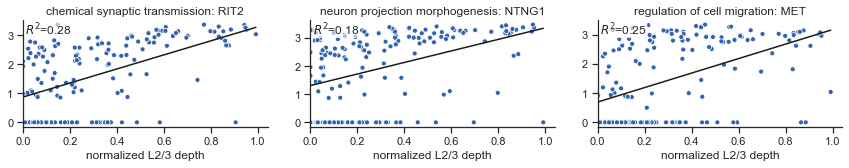

In [18]:
features = [
        'RIT2',
       'NTNG1',
       'MET'
]
labels = [
    "chemical synaptic transmission: RIT2",
    "neuron projection morphogenesis: NTNG1",
    "regulation of cell migration: MET",
]
plot_depth_scatters(data, features, labels, horizontal=True)

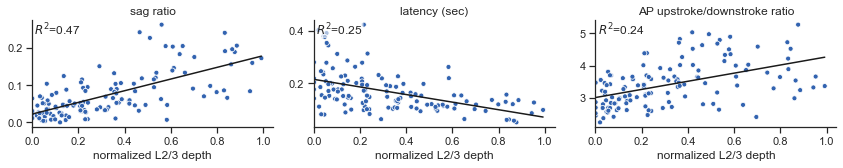

In [19]:
features = [
        'sag',
       'latency_rheo',
       'upstroke_downstroke_ratio_long_square'
]
labels = [efeat_units[feat] for feat in features]

plot_depth_scatters(data, features, labels, horizontal=True)

# Fig5 morph

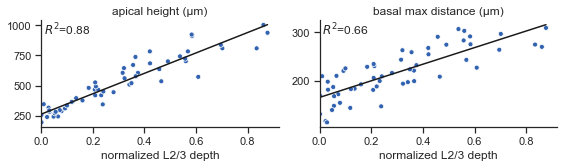

In [20]:
data = human_df[human_df.cluster.str.contains('FREM')]
features = [
       'apical_dendrite_extent_y',
       'basal_dendrite_max_euclidean_distance_none'
]
labels = [mfeat_dict[feat]+' (µm)' for feat in features]

x = 'L23_depth_normalized'
fig, axes = plt.subplots(1,2, figsize=(8,2.5), sharex=True)

for i, ax in enumerate(axes):
    res = utils.plot_fit(data, features[i], x, print_pvals=False, palette=palette, ax=ax)
#     sns.scatterplot(data=data, x=x, y=features[i], palette=palette, ax=ax)
    sns.despine()
    ax.set_ylabel('')
    ax.set_xlabel('normalized L2/3 depth')
    ax.set_title(labels[i], loc='center', pad=5)

    summary = "$R^2$={:.2g}".format(res["rsquared"])
    props = dict(boxstyle='round', facecolor='white', alpha=0.6, pad=0.01)
    ax.text(0.01, 0.99, summary, transform=ax.transAxes, bbox=props,
        verticalalignment='top', horizontalalignment='left')
    ax.set_xlim(0,None)
fig.tight_layout(h_pad=0.5)

# Fig 6

In [21]:
data = human_df.loc[lambda df: df["SeuratMapping"].str.contains("Exc L3") | df.Is_deep_FREM3]
data['width_long_square'] *= 1000
data.cluster.cat.remove_unused_categories(inplace=True)

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
data.cluster.value_counts()

COL22A1    42
FREM3      30
CARM1P1    20
Name: cluster, dtype: int64

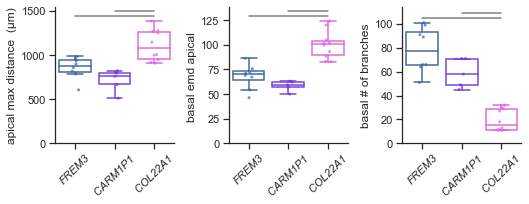

In [23]:
features = [
    'apical_dendrite_max_euclidean_distance_none',
    'basal_dendrite_emd_with_apical_dendrite_none',
    'basal_dendrite_num_branches_none',
]
labels = [mfeat_dict[feat] for feat in features]
labels[0] += ' (μm)'
plot_box_cluster_feature(data, features, labels, figsize=(7.5,3), horizontal=True, label_yaxis=True, strip_width=0.1, 
                         pairs_sets=['all'], cutoff=0.05)
plt.tight_layout()

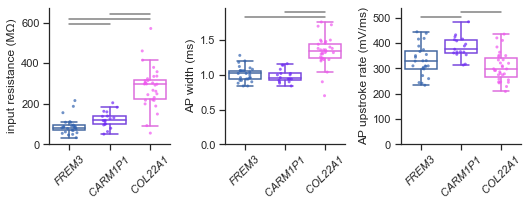

In [24]:
features = [
    'input_resistance',
    'width_long_square',
    'upstroke_long_square',
]
labels = [efeat_units[feat] for feat in features]

plot_box_cluster_feature(data, features, labels, figsize=(7.5,3), horizontal=True, label_yaxis=True, 
                         pairs_sets=['all'], cutoff=0.05)
plt.tight_layout()

# Supplement tables

In [25]:
from statsmodels.stats import multitest
def run_regressions(df, features, variable, pval=None, cov_type='HC3', fdr_method='fdr_bh',):
    label = 'rsquared'
    fdr_method='fdr_bh'
    
    results = (utils.fit_models(df, [variable], features, cov_type=cov_type).set_index('feature')
        .sort_values('rsquared', ascending=False)
    )
    if pval is None:
        pval = [col for col in results if col.startswith('pval_')]
    results = results.dropna(subset=pval)
    results[pval] = (
        results[pval].pipe(pd.DataFrame)#in case this is Series
        .apply(lambda col: multitest.multipletests(col, method=fdr_method)[1]).astype(float)
    )
    cols = [
        'nobs',
        f"pval_{variable}",
        'rsquared'
    ]
    names = [
        'number cells',
        'p-value (FDR-BH)',
        'Rsquared'
    ]
    results = (results[cols]
               .rename(columns=dict(zip(cols, names)))
          )
    return results

### Homologous types ANOVA

In [26]:
data = mouse_df
data.cluster.cat.remove_unused_categories(inplace=True)
features = ephys_df.columns
results = run_regressions(data, features, "cluster").rename(index=efeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_mouse_clusters_ephys.csv')
results.head()

,number cells,p-value (FDR-BH),Rsquared
feature,,,
AP downstroke rate,120.0,0.008326,0.122708
input resistance,117.0,0.012837,0.117814
AP width,120.0,0.008326,0.115987
AP upstroke/downstroke ratio,120.0,0.049575,0.084561
initial firing rate,114.0,0.012837,0.082878


In [27]:
data = human_df.loc[lambda df: df["SeuratMapping"].str.contains("Exc L2") ]
data.cluster.cat.remove_unused_categories(inplace=True)
features = ephys_df.columns
results = run_regressions(data, features, "cluster").rename(index=efeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_homologous_clusters_ephys.csv')
results.head()

,number cells,p-value (FDR-BH),Rsquared
feature,,,
input resistance,235.0,5.607528e-09,0.160844
f-I slope,228.0,2.494204e-06,0.124965
rheobase,235.0,5.607528e-09,0.122328
sag,234.0,5.639215e-08,0.097536
mean firing rate,235.0,5.514554e-05,0.096522


In [28]:
data = mouse_df
data.cluster.cat.remove_unused_categories(inplace=True)
features = morph_df.columns
results = run_regressions(data, features, "cluster").rename(index=mfeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_mouse_clusters_morph.csv')
results.head()

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1848: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of con

,number cells,p-value (FDR-BH),Rsquared
feature,,,
soma relative depth,60.0,0.015652,0.226956
apical soma x %,60.0,0.015652,0.211463
basal emd apical,60.0,0.022603,0.205374
apical # of branches,60.0,0.015652,0.205305
apical hist PC2,60.0,0.036951,0.201715


In [29]:
(results.Rsquared>0.15).sum()

12

In [30]:
(results["p-value (FDR-BH)"]<0.05).sum()

11

In [31]:
data = human_df.loc[lambda df: df["SeuratMapping"].str.contains("Exc L2")]
data.cluster.cat.remove_unused_categories(inplace=True)
features = morph_df.columns
results = run_regressions(data, features, "cluster").rename(index=mfeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_homologous_clusters_morph.csv')
results.head()

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)


,number cells,p-value (FDR-BH),Rsquared
feature,,,
height (apical over basal),94.0,0.000264,0.263233
apical max distance,94.0,0.000110,0.189049
apical # of branches,94.0,0.000110,0.187567
apical total surf area,94.0,0.000110,0.181247
basal total surf area,94.0,0.000110,0.176741


In [32]:
(results.Rsquared>0.15).sum()

16

In [33]:
(results["p-value (FDR-BH)"]<0.05).sum()

36

### FREM3 depth correlations

In [34]:
data = human_df[human_df["cluster"].str.contains('FREM3')]
features = ephys_df.columns
results = run_regressions(data, features, "L23_depth_normalized").rename(index=efeat_dict)

results.head()
# results.to_csv('/home/tom.chartrand/figs/supp_depth_ephys.csv')

,number cells,p-value (FDR-BH),Rsquared
feature,,,
sag,130.0,5.645524e-15,0.469559
latency,130.0,5.938375e-10,0.252150
AP upstroke/downstroke ratio,130.0,8.028307e-07,0.238038
resting membrane potential,130.0,6.887549e-06,0.186144
AP upstroke rate,130.0,1.845286e-05,0.157825


In [35]:
print((results["p-value (FDR-BH)"]<0.05).sum(), (results["p-value (FDR-BH)"]<0.01).sum())

9 7


In [36]:
data = human_df[human_df["cluster"].str.contains('FREM3')]
features = morph_df.columns
results = run_regressions(data, features, "L23_depth_normalized").rename(index=mfeat_dict)

results.head()
# results.to_csv('/home/tom.chartrand/figs/supp_depth_morph.csv')

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)


,number cells,p-value (FDR-BH),Rsquared
feature,,,
soma relative depth,56.0,5.416485e-21,0.908861
depth from pia,56.0,4.106712e-24,0.886826
apical height,56.0,9.276267e-22,0.880304
apical max distance,56.0,5.771094e-21,0.853979
apical bias y,56.0,3.592461e-21,0.843074


In [37]:
print((results["p-value (FDR-BH)"]<0.05).sum(), (results["p-value (FDR-BH)"]<0.01).sum())

37 28


### Deep types ANOVA

In [38]:
data = human_df.loc[lambda df: df["SeuratMapping"].str.contains("Exc L3") | df.Is_deep_FREM3]
data.cluster.cat.remove_unused_categories(inplace=True)
features = ephys_df.columns
results = run_regressions(data, features, "cluster").rename(index=efeat_dict)
# results.to_csv('/home/tom.chartrand/figs/supp_deep_clusters_ephys.csv')
results.head()

,number cells,p-value (FDR-BH),Rsquared
feature,,,
input resistance,73.0,3.263478e-12,0.615442
AP width,73.0,1.337962e-09,0.524601
AP downstroke rate,73.0,1.555603e-08,0.471647
rheobase,73.0,9.769518e-08,0.441945
time constant τ,73.0,3.599266e-07,0.400162


In [39]:
data = human_df.loc[lambda df: df["SeuratMapping"].str.contains("Exc L3") | df.Is_deep_FREM3]
data.cluster.cat.remove_unused_categories(inplace=True)
features = morph_df.columns
results = run_regressions(data, features, "cluster").rename(index=efeat_dict)

# results.to_csv('/home/tom.chartrand/figs/supp_deep_clusters_morph.csv')
results.head()

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)


,number cells,p-value (FDR-BH),Rsquared
feature,,,
basal_dendrite_num_branches_none,23.0,0.000002,0.809941
basal_dendrite_total_length_none,23.0,0.000002,0.808850
basal_dendrite_total_surface_none,23.0,0.000006,0.769410
basal_dendrite_extent_x,23.0,0.000035,0.751354
apical_dendrite_extent_x_over_y,23.0,0.000015,0.736895


In [40]:
(results["p-value (FDR-BH)"]<0.05).sum()

24

In [41]:
(results.Rsquared>0.4).sum()

20